In [1]:
import matplotlib
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [2]:
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "gabriola"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

logo = plt.imread('../../Branding/globe.png')

In [3]:
logo = plt.imread('../../Branding/light_logo_1.png')

In [4]:
import numpy as np

def scale_lw(df: gpd.GeoDataFrame, column_name: str, min_value: float = 0.005, max_value: float = 0.6):
    leftSpan = np.amax(df[column_name]) - np.amin(df[column_name])
    rightSpan = max_value - min_value
    valueScaled = (df[column_name] - np.amin(df[column_name])) / leftSpan
    df[f'LW_{column_name}'] = min_value + (valueScaled * rightSpan)
    return df

In [5]:
from shapely.ops import unary_union

def merge_basins(basin_df):
    geoms = [unary_union(basin_df.loc[basin_df['MAJ_NAME'] == poly_basin].geometry.tolist()) for poly_basin in basin_df.MAJ_NAME.unique().tolist()]
    geoms_area = [geom.area for geom in geoms]
    names = [poly_basin for poly_basin in basin_df.MAJ_NAME.unique().tolist()]
    basin_df = gpd.GeoDataFrame(pd.DataFrame({"name": names, "area": geoms_area}), geometry=geoms)
    return basin_df


In [6]:
def color_merge(basin_df, colors_df):
    basin_df = pd.merge(basin_df, colors_df, left_on='name', right_on='basin', how='left')
    basin_df = basin_df[['name', 'geometry', 'colors']]
    basin_df = basin_df[~basin_df['colors'].isna()]
    basin_df.plot(color=basin_df['colors'])
    return basin_df

In [7]:
from cartopy.crs import Projection, _WarpedRectangularProjection
from abc import ABCMeta    
import shapely.geometry as sgeom

class TestProjection(Projection):
    _handles_ellipses = False

    def __init__(self, name, central_latitude=0.0,
                 central_longitude=0.0, globe=None):
        proj4_params = [('proj', name), ('lat_0', central_latitude),
                        ('lon_0', central_longitude)]
        super().__init__(proj4_params, globe=globe)
        self._max = 5e7
        self.threshold = 1e5

    @property
    def boundary(self):
        return sgeom.Point(0, 0).buffer(self._max).exterior

    @property
    def x_limits(self):
        return (-self._max, self._max)

    @property
    def y_limits(self):
        return (-self._max, self._max)

In [8]:
lakes = gpd.read_file("../../PythonMapsData/NaturalEarth/10m_physical/ne_10m_lakes.shp")

In [9]:
basins = pd.concat([gpd.read_file("../../Nature/rivers/data/basins/europe/hydrobasins_europe.shp"),
                    gpd.read_file("../../Nature/rivers/data/basins/nearest/hydrobasins_neareast.shp"),
                    gpd.read_file("../../Nature/rivers/data/basins/asia/hydrobasins_asia.shp")])

In [10]:
df = gpd.read_file('../../PythonMapsData/NaturalEarth/10m_cultural/ne_10m_admin_0_countries.shp')
russia = df[df['ADMIN'] == 'Russia']

In [11]:
rusia_2 = russia.copy()

Polygons = list(russia.iloc[0].geometry)
del Polygons[2]
polygons_to_wrap = []
polygons_to_leave = []

for i, polygon in enumerate(Polygons):
    if polygon.centroid.x < -150:
        polygons_to_wrap.append(polygon)
    else:
        polygons_to_leave.append(polygon)

C:\Users\symmy\AppData\Local\Temp\ipykernel_10504\4066413499.py:3: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  Polygons = list(russia.iloc[0].geometry)
C:\Users\symmy\AppData\Local\Temp\ipykernel_10504\4066413499.py:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  Polygons = list(russia.iloc[0].geometry)


In [12]:
russia = gpd.GeoDataFrame(pd.DataFrame({'Name': np.arange(len(polygons_to_wrap))}), 
                           crs=russia.crs, 
                           geometry=polygons_to_wrap)

russia_2 = gpd.GeoDataFrame(pd.DataFrame({'Name': np.arange(len(polygons_to_leave))}), 
                           crs=russia.crs, 
                           geometry=polygons_to_leave)

In [13]:
basins_1 = gpd.sjoin(basins, russia, predicate='intersects')

basins_2 = gpd.sjoin(basins, russia_2, predicate='intersects')


In [14]:
basins_1 = merge_basins(basins_1)

basins_2 = merge_basins(basins_2)


In [15]:
colors = {
     'Siberia, West Coast': 'black', 
     'Ob': '#ffa500', 
     'Lena': '#808000', 
     'Yenisey': '#483d8b',
     'Siberia, North Coast': '#dc143c',
     'Amur': '#BE0032', 
     'Gobi Interior': 'lightgray', 
     'Volga': 'red', 
     'Arabian Peninsula': 'lightgray', 
     'Yangtze': 'blue', 
     'Tarim Interior': '#008856', 
     'Ganges - Bramaputra': 'darkgreen', 
     'Kara Sea Coast': '#228B22', 
     'Syr Darya': '#3cb371', 
     'Russia, Barents Sea Coast': 'blue', 
     'Caspian Sea, East Coast': '#2f4f4f', 
     'Tigris - Euphrates': '#0000ff',
     'Amu Darya': '#ff00ff', 
     'Huang He': 'red', 
     'Indus': '#BE0032', 
     'Central Iran': '#ff1493',
     'Mekong': 'darkgreen', 
     'Caspian Sea Coast': 'black', 
     'China Coast': 'blue',
     'Don': '#808000', 
     'Scandinavia, North Coast': '#483d8b', 
     'Lake Balkash': '#dc143c', 
     'Red Sea, East Coast': '#000080',
     'Sabarmati': 'blue',
     'Northern Dvina': '#8b008b',
     'Iceland': '#A1CAF1',
     'Finland': '#ff4500', 
     'Plateau of Tibet Interior': '#ffa500', 
     'Japan': '#008856', 
     'Bo Hai - Korean Bay, North Coast': '#882D17', 
     'Caspian Sea, South West Coast': '#228B22', 
     'Neva': '#3cb371',
     'Xun Jiang': '#875692', 
     'Ziya He, Interior': '#2f4f4f', 
     'Irrawaddy': 'crimson', 
     'Dnieper': '#ff00ff', 
     'Black Sea, South Coast': '#1e90ff', 
     'Mediterranean Sea, East Coast': '#db7093',
     'Ural': '#ffa500', 
     'Godavari': 'blue', 
     'Peninsula Malaysia': 'blue',
     'Philippines': '#A1CAF1', 
     'Salween': '#483d8b', 
     'Helmand': 'black',
     'Krishna': '#808000', 
     'Persian Gulf Coast': '#483d8b',
     'North and South Korea': 'black', 
     'Eastern Jordan - Syria': '#ffa500',
     'Russia, South East Coast': '#808000',
     'Arctic Ocean Islands': 'darkgreen',
     'Arabian Sea Coast': '#483d8b', 
     'Hamun-i-Mashkel': '#dc143c',
     'North Borneo Coast': 'lime', 
     'Viet Nam, Coast': 'blue', 
     'Hong (Red River)': '#8b008b', 
     'Chao Phraya': '#ff4500', 
     'Black Sea, North Coast': 'blue', 
     'Mahandi': 'crimson',
     'Daugava': 'darkgreen',
     'Kalimantan': '#228B22', 
     'Narmada': 'purple',
     'Farahrud': '#875692', 
     'Adriatic Sea - Greece - Black Sea Coast': '#2f4f4f', 
     'Bay of Bengal, North East Coast': '#0000ff',
     'India West Coast': '#ff00ff', 
     'Cauvery': '#1e90ff',
     'Pennar': '#BE0032', 
     'Tapti': '#ff1493',
     'Yasai': '#882D17', 
     'South China Sea Coast': 'black',
     'Narva': 'blue',
     'Sri Lanka': '#808000', 
     'India East Coast': '#483d8b',
     'India South Coast': '#dc143c', 
     'Sittang': '#000080', 
     'Brahamani': 'darkorange',
     'Gulf of Thailand Coast': '#8b008b', 
     'Dead Sea': '#ff4500', 
     'India North East Coast': '#ffa500',
     'Mahi': '#008856', 
     'Hainan': '#882D17', 
     'Baltic Sea Coast': '#228B22', 
     'Sinai Peninsula': '#3cb371',
     'Andaman - Nicobar Islands': '#875692', 
     'Taiwan': '#2f4f4f',
     'Lake Chad': 'black',
     'Nile': 'blue',
     'Rift Valley': '#808000', 
     'Congo': '#483d8b', 
     'Niger': '#dc143c', 
     'Volta': '#000080', 
     'Africa, West Coast': 'green', 
     'Africa, North West Coast': '#8b008b', 
     'Mediterranean South Coast': '#ff4500',
     'Africa, Red Sea - Gulf of Aden Coast': '#ffa500',
     'Shebelli - Juba': '#008856', 
     'Africa, East Central Coast': '#882D17',
     'Madasgacar': '#228B22', 
     'Zambezi': '#3cb371', 
     'Africa, Indian Ocean Coast': '#875692', 
     'Limpopo': '#2f4f4f',
     'South Africa, South Coast': '#0000ff',
     'South Africa, West Coast': '#ff00ff', 
     'Orange': '#1e90ff', 
     'Africa, South Interior': '#db7093',
     'Namibia, Coast': '#ff1493',
     'Angola, Coast': 'darkgreen', 
     'Gulf of Guinea': '#ee82ee',
     'Senegal': '#A1CAF1', 
     'Africa, North Interior': 'orange',
     'Philippines': '#ff00ff', 
     'North Marina Islands and Guam': '#483d8b',
     'Palau and East Indonesia': '#ffa500',
     'North Borneo Coast': 'green',
     'Micronesia': 'blue', 
     'Sumatra': '#dc143c', 
     'Kalimantan': 'blue', 
     'Sulawesi': '#483d8b',
     'Irian Jaya Coast': '#000080',
     'Papua New Guinea Coast': '#3cb371',
     'Sepik': '#875692', 
     'Fly': '#2f4f4f',
     'Java - Timor': 'crimson',
     'Solomon Islands': '#ff00ff',
     'Australia, North Coast': 'darkgreen',
     'South Pacific Islands': '#db7093',
     'Australia, Interior': '#ffa500',
     'Australia, East Coast': 'blue', 
     'Australia, West Coast': '#ee82ee', 
     'Murray - Darling': 'crimson',
     'Australia, South Coast': '#483d8b',
     'New Zealand': 'black',
     'Tasmania': '#808000',
     'Spain - Portugal, Atlantic Coast': 'black',
     'Douro': 'blue', 
     'Tagus': '#808000', 
     'Guadiana': '#483d8b',
     'Spain, South and East Coast': '#dc143c', 
     'Guadalquivir': '#000080', 
     'Ebro': 'green',
     'Gironde': '#8b008b',
     'France, West Coast': '#ff4500', 
     'Loire': '#ffa500', 
     'Seine': '#008856',
     'Rhône': '#882D17', 
     'France, South Coast': '#228B22',
     'England and Wales': '#3cb371',  
     'Ireland': '#875692', 
     'Scotland': '#2f4f4f',
     'Scheldt': '#0000ff',
     'Rhine': 'green',
     'Maas': '#1e90ff',
     'Ems - Weser': '#db7093', 
     'Po': 'black', 
     'Italy, West Coast': 'darkgreen', 
     'Mediterranean Sea Islands': '#ee82ee', 
     'Tiber': '#A1CAF1',
     'Italy, East Coast': 'orange', 
     'Danube': 'red', 
     'Elbe': 'blue', 
     'Sweden': '#808000', 
     'Wisla': '#483d8b', 
     'Oder': '#008856', 
     'Adriatic Sea - Greece - Black Sea Coast': '#000080', 
     'Dnieper': 'green', 
     'Poland Coast': '#8b008b',
     'Neman': '#ff4500', 
     'Dniester': '#ffa500', 
     'Don': '#dc143c',
     'Volga': 'blue', 
     'Ural': '#228B22', 
     'Narva': '#3cb371',
     'Black Sea, North Coast': '#875692',
     'Caspian Sea Coast': '#2f4f4f', 
     'Baltic Sea Coast': '#0000ff', 
     'Neva': '#ff00ff', 
     'Scandinavia, North Coast': '#1e90ff', 
     'Finland': '#db7093', 
     'Russia, Barents Sea Coast': '#ff1493',
     'Northern Dvina': 'darkgreen', 
     'Denmark - Germany Coast': '#ee82ee',
     'Daugava': '#A1CAF1', 
     'Black Sea, South Coast': 'orange',
     'Mediterranean Sea, East Coast': 'black',
     'Caspian Sea, South West Coast': 'blue',
     'Tigris - Euphrates': '#808000',
     'Gulf of Mexico, North Atlantic Coast': 'black',
     'United States, North Atlantic Coast': 'orange', 
     'Mississippi - Missouri': '#BE0032', 
     'Gulf Coast': '#808000',
     'California': '#483d8b', 
     'Great Basin': '#3cb371',
     'North America, Colorado': '#000080', 
     'Columbia and Northwestern United States': 'green',
     'Pacific and Arctic Coast': '#8b008b', 
     'Fraser': '#ff4500', 
     'Saskatchewan - Nelson': '#ffa500', 
     'Northwest Territories': '#008856',
     'Hudson Bay Coast': '#882D17', 
     'Atlantic Ocean Seaboard': '#228B22', 
     'Churchill': '#dc143c',
     'St Lawrence': '#875692',
     'St John': '#2f4f4f',
     'Mackenzie': '#0000ff', 
     'Arctic Ocean Islands': '#ff00ff',
     'Río Grande - Bravo': '#1e90ff', 
     'Mexico, Northwest Coast': '#db7093', 
     'Baja California': 'black',
     'Mexico, Interior': '#ff1493',
     'North Gulf': 'darkgreen', 
     'Río Verde': '#ee82ee', 
     'Río Lerma': '#A1CAF1',
     'Pacific Central Coast': '#875692', 
     'Río Balsas': '#008856',
     'Isthmus of Tehuantepec': '#0067A5',
     'Grijalva - Usumacinta': '#BE0032', 
     'Yucatán Peninsula': '#222222', 
     'Southern Central America': 'orange', 
     'Caribbean': '#F3C300', 
     'Papaloapan': 'blue',
     'Caribbean Coast': 'black',
     'Magdalena': 'blue',
     'Orinoco': '#808000', 
     'Northeast South America, South Atlantic Coast': '#483d8b',
     'Amazon': '#dc143c', 
     'Tocantins': '#000080', 
     'North Brazil, South Atlantic Coast': 'green', 
     'Parnaiba': '#8b008b',
     'East Brazil, South Atlantic Coast': '#ff4500', 
     'Sao Francisco': '#ffa500', 
     'Uruguay - Brazil, South Atlantic Coast': '#008856', 
     'La Plata': '#882D17',
     'North Argentina, South Atlantic Coast': '#228B22', 
     'South America, Colorado': '#3cb371', 
     'Negro': '#875692', 
     'South Argentina, South Atlantic Coast': '#2f4f4f', 
     'Central Patagonia Highlands': '#0000ff', 
     'Colombia - Ecuador, Pacific Coast': '#ff00ff', 
     'Peru, Pacific Coast': '#1e90ff',
     'North Chile, Pacific Coast': '#db7093',
     'South Chile, Pacific Coast': '#ff1493',
     'La Puna Region': 'darkgreen', 
     'Salinas Grandes': '#ee82ee', 
     'Mar Chiquita': '#A1CAF1', 
     'Pampas Region': 'orange',
     }

colors_df = pd.DataFrame({'basin': colors.keys(), 'colors': colors.values()})

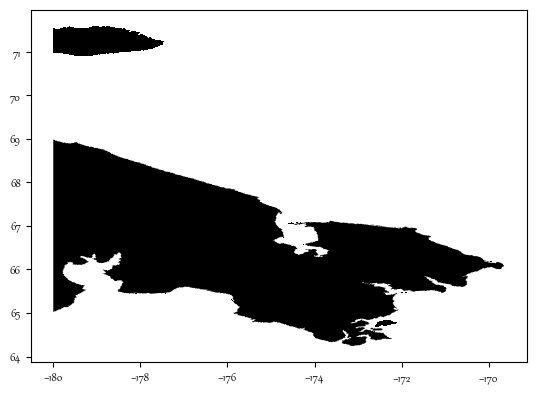

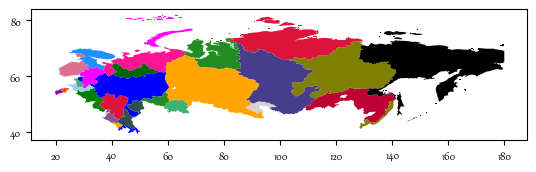

In [16]:
basins_1 = color_merge(basins_1, colors_df)

basins_2 = color_merge(basins_2, colors_df)

In [17]:
lakes_1 = gpd.sjoin(lakes, basins_1, op="within")

lakes_2 = gpd.sjoin(lakes, basins_2, op="within")


lakes = pd.concat([lakes_1, lakes_2])

C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\symmy\AppData\Local\Temp\ipykernel_10504\1424257179.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  lakes_1 = gpd.sjoin(lakes, basins_1, op="within")
C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\symmy\AppData\Local\Temp\ipykernel_10504\1424257179.py:3: UserWarning: CRS mismatch

In [18]:
rivers = pd.concat([gpd.read_file("../../Nature/rivers/data/rivers/europe/a00000009.gdbtable"),
                    gpd.read_file("../../Nature/rivers/data/rivers/asia/a00000009.gdbtable"),
                    gpd.read_file("../../Nature/rivers/data/rivers/siberia/a00000009.gdbtable"),
                    gpd.read_file("../../Nature/rivers/data/rivers/artic/a00000009.gdbtable")])

In [19]:
rivers = rivers.loc[rivers['ORD_FLOW'] < 8]

In [20]:
rivers_basins_1 = gpd.sjoin(rivers, basins_1, op='within')

rivers_basins_2 = gpd.sjoin(rivers, basins_2, op='within')


C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\symmy\AppData\Local\Temp\ipykernel_10504\602249499.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  rivers_basins_1 = gpd.sjoin(rivers, basins_1, op='within')
C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\symmy\AppData\Local\Temp\ipykernel_10504\602249499.py:3: UserWarning: CRS m

In [21]:
rivers_basins_1_geometry = rivers_basins_1.geometry

rivers_basins_2_geometry = rivers_basins_2.geometry

In [22]:
import shapely

rivers_basins_1_geometry = rivers_basins_1_geometry.apply(lambda x: shapely.affinity.translate(x, xoff=340, yoff=0))

In [23]:
rivers_basins_2_geometry = rivers_basins_2_geometry.apply(lambda x: shapely.affinity.translate(x, xoff=-20, yoff=0))

In [24]:
lakes_geometry = lakes.geometry

lakes_geometry = lakes_geometry.apply(lambda x: shapely.affinity.translate(x, xoff=-20, yoff=0))

In [25]:
rivers_basins_1.geometry = rivers_basins_1_geometry

rivers_basins_2.geometry = rivers_basins_2_geometry

lakes.geometry = lakes_geometry

In [26]:
rivers_basins_test = pd.concat([rivers_basins_1, rivers_basins_2])

In [27]:
rivers_basins_test = scale_lw(rivers_basins_test, 'DIST_UP_KM', min_value=0.03, max_value=1)

In [28]:
print(rivers_basins_test)

        HYRIV_ID  NEXT_DOWN  MAIN_RIV  LENGTH_KM  DIST_DN_KM  DIST_UP_KM  \
24678   80024679          0  80024679       9.16    0.000000   41.000000   
24731   80024732   80024679  80024679       1.54    9.100000   32.200001   
24873   80024874   80024780  80024780       1.94    3.300000   58.900002   
24874   80024875   80024800  80024800       5.23    3.300000   17.600000   
24951   80024952   80024732  80024679       8.02   10.700000   30.500000   
...          ...        ...       ...        ...         ...         ...   
672226  30672227   30671865  30649806       4.66  414.899994   55.900002   
672260  30672261   30671932  30649806       4.29  398.399994   35.799999   
672346  30672347   30672227  30649806       1.58  419.600006   51.200001   
672499  30672500   30672261  30649806       3.68  402.500000   31.700001   
673088  30673089   30673060  30649806       0.46  433.600006   37.299999   

        CATCH_SKM  UPLAND_SKM  ENDORHEIC  DIS_AV_CMS  ORD_STRA  ORD_CLAS  \
24678   29.

In [47]:

print(rivers_basins_test)
print(rivers_basins_test[['colors', 'name']].drop_duplicates())
#rivers_basins = rivers_basins.replace('black', 'orange')
#rivers_basins = rivers_basins.replace('#ff00ff', 'purple')

colors = rivers_basins_test['colors'].drop_duplicates()
MAJ_NAME = rivers_basins_test['name'].drop_duplicates()


        HYRIV_ID  NEXT_DOWN  MAIN_RIV  LENGTH_KM  DIST_DN_KM  DIST_UP_KM  \
24678   80024679          0  80024679       9.16    0.000000   41.000000   
24731   80024732   80024679  80024679       1.54    9.100000   32.200001   
24873   80024874   80024780  80024780       1.94    3.300000   58.900002   
24874   80024875   80024800  80024800       5.23    3.300000   17.600000   
24951   80024952   80024732  80024679       8.02   10.700000   30.500000   
...          ...        ...       ...        ...         ...         ...   
672226  30672227   30671865  30649806       4.66  414.899994   55.900002   
672260  30672261   30671932  30649806       4.29  398.399994   35.799999   
672346  30672347   30672227  30649806       1.58  419.600006   51.200001   
672499  30672500   30672261  30649806       3.68  402.500000   31.700001   
673088  30673089   30673060  30649806       0.46  433.600006   37.299999   

        CATCH_SKM  UPLAND_SKM  ENDORHEIC  DIS_AV_CMS  ORD_STRA  ORD_CLAS  \
24678   29.

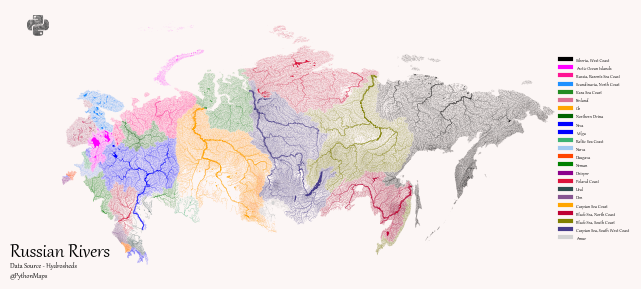

In [54]:

from matplotlib.lines import Line2D

fig = plt.figure(facecolor='#FCF6F5FF')
fig.set_size_inches(7, 3.5)
ax = plt.axes()
rivers_basins_test.plot(ax=ax, edgecolor='face', 
                   color=rivers_basins_test['colors'], 
                   lw=rivers_basins_test['LW_DIST_UP_KM'])
lakes.plot(ax=ax, color=lakes['colors'])
ax.axis('off')
newax = fig.add_axes([0.08, 0.8, 0.06, 0.06], anchor='NE', zorder=-1)
newax.imshow(logo)
newax.axis('off')
txt = ax.text(-0.05, 0.08, "Russian Rivers",
              size=16,
              color='black',
              transform = ax.transAxes)
txt = ax.text(-0.05, 0.0, "Data Source - Hydrosheds\n@PythonMaps",
              size=6,
              color='black',
              transform = ax.transAxes)

LegendElement = [Line2D([0],[0], color=color, lw=3, label=label) for color, label in zip(colors, MAJ_NAME)]
ax.legend(handles=LegendElement, fontsize=4, frameon=False, framealpha=0, bbox_to_anchor=(1.1, 0.84))

plt.savefig("outputs/russia.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
=

In [37]:
import glob

files = glob.glob("outputs/russia/*.png")
ignore = [(file.split("\\")[1]).split(".")[0] for file in files]

In [39]:
print(ignore)

['adams_hemi', 'adams_ws1', 'adams_ws2', 'aeqd', 'affine', 'airy', 'aitoff', 'alsk', 'apian', 'august', 'bacon', 'bertin1953', 'bipc', 'boggs', 'calcofi', 'cart', 'cass', 'cc', 'cea', 'collg', 'col_urban', 'comill', 'crast', 'denoy', 'eck1', 'eck2', 'eck3', 'eck4', 'eck5', 'eck6', 'eqc', 'eqearth', 'fahey', 'fouc', 'fouc_s', 'gall', 'geocent', 'geogoffset', 'gins8', 'gnom', 'goode', 'gs48', 'gs50', 'guyou', 'hammer', 'hatano', 'healpix', 'igh', 'igh_o', 'isea', 'rhealpix']


aea Albers Equal Area
Invalid projection: +proj=aea +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): aea: Invalid value for lat_1 and lat_2: |lat_1 + lat_2| should be > 0)
Call the gyno, cunts fucked
axisswap Axis ordering
Invalid projection: +proj=axisswap +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1028 (Mutually exclusive arguments): axisswap: order and axis parameters are mutually exclusive.)
Call the gyno, cunts fucked
bonne Bonne (Werner lat_1=90)
Invalid projection: +proj=bonne +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): bonne: Invalid value for lat_1: |lat_1| should be > 0)
Call the gyno, cunts fucked
ccon Central Conic
Invalid projection: +proj=ccon +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Inva

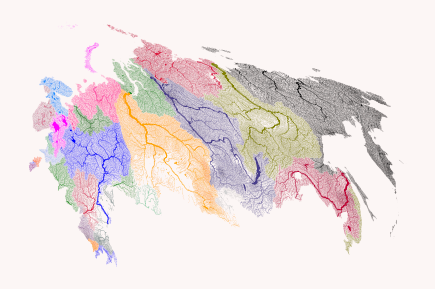

kav7 Kavraisky VII


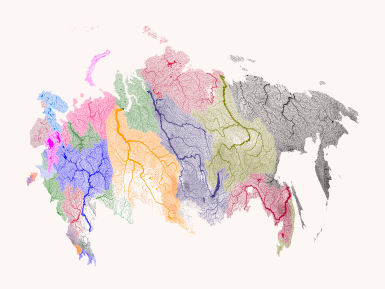

krovak Krovak


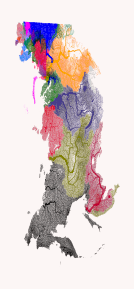

labrd Laborde
Invalid projection: +proj=labrd +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): labrd: Invalid value for lat_0: lat_0 should be different from 0)
Call the gyno, cunts fucked
laea Lambert Azimuthal Equal Area


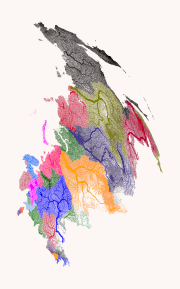

lagrng Lagrange


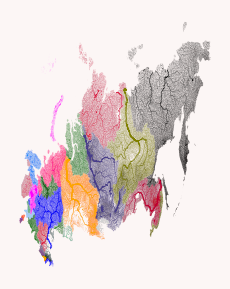

larr Larrivee


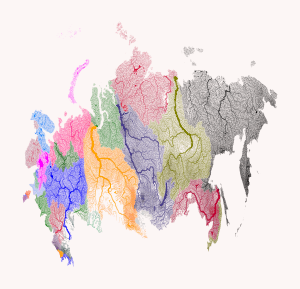

lask Laskowski


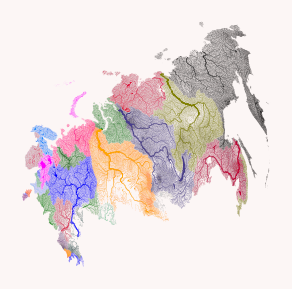

lonlat Lat/long (Geodetic)


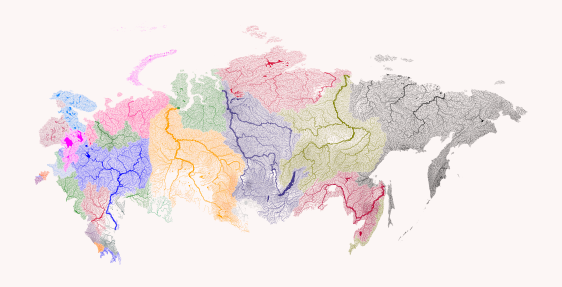

latlon Lat/long (Geodetic alias)


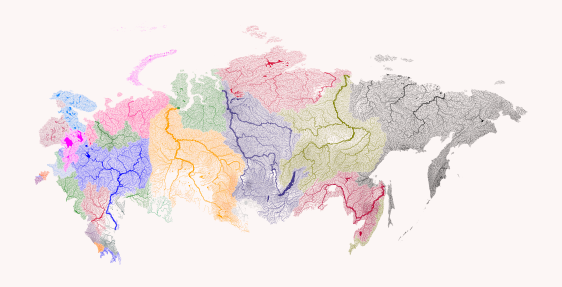

latlong Lat/long (Geodetic alias)


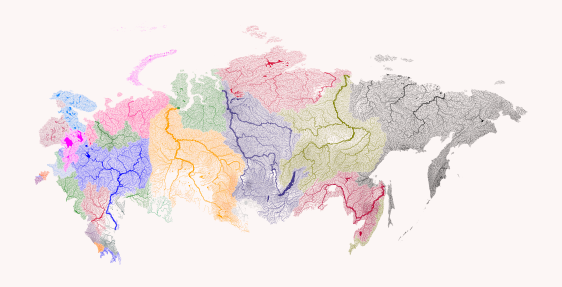

longlat Lat/long (Geodetic alias)


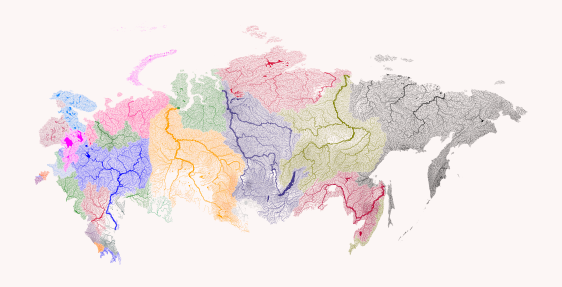

lcc Lambert Conformal Conic
Invalid projection: +proj=lcc +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): lcc: Invalid value for lat_1 and lat_2: |lat_1 + lat_2| should be > 0)
Call the gyno, cunts fucked
lcca Lambert Conformal Conic Alternative
Invalid projection: +proj=lcca +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): lcca: Invalid value for lat_0: it should be different from 0.)
Call the gyno, cunts fucked
leac Lambert Equal Area Conic


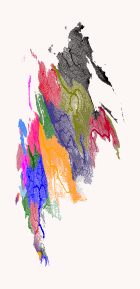

lee_os Lee Oblated Stereographic


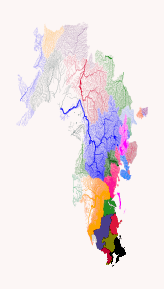

loxim Loximuthal


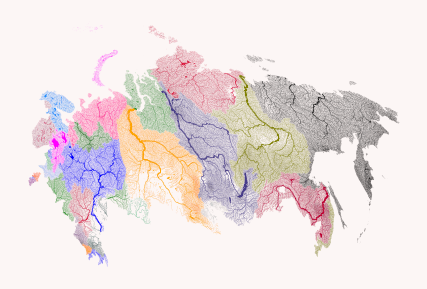

lsat Space oblique for LANDSAT
Invalid projection: +proj=lsat +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): lsat: Invalid value for lsat: lsat should be in [1, 5] range)
Call the gyno, cunts fucked
mbt_s McBryde-Thomas Flat-Polar Sine (No. 1)


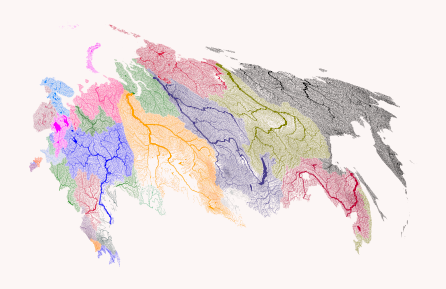

mbt_fps McBryde-Thomas Flat-Pole Sine (No. 2)


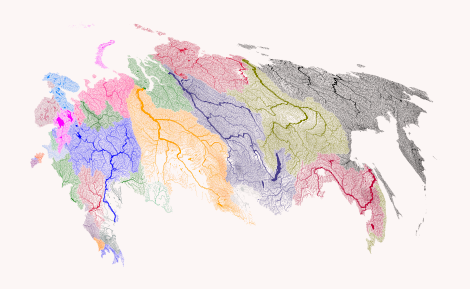

mbtfpp McBride-Thomas Flat-Polar Parabolic


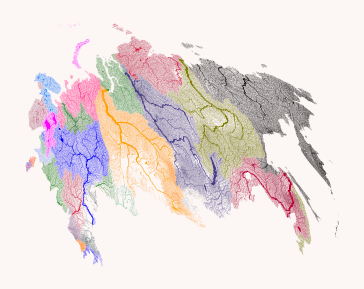

mbtfpq McBryde-Thomas Flat-Polar Quartic


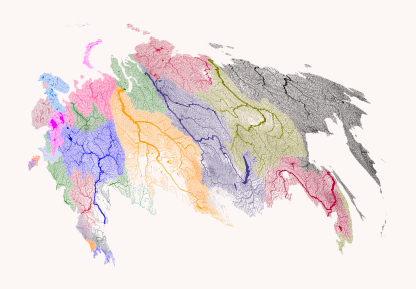

mbtfps McBryde-Thomas Flat-Polar Sinusoidal


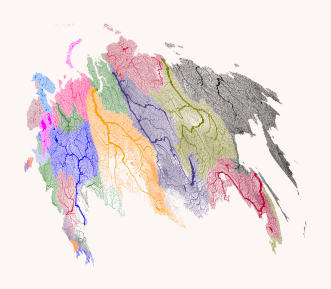

merc Mercator


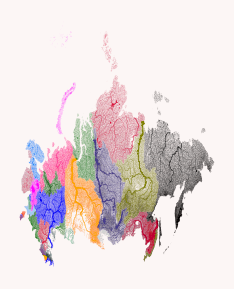

mil_os Miller Oblated Stereographic


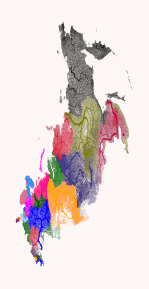

mill Miller Cylindrical


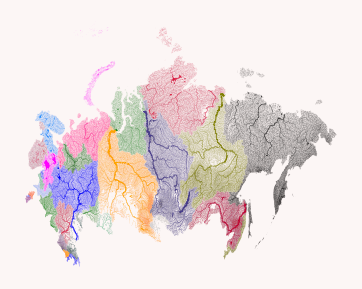

misrsom Space oblique for MISR
Invalid projection: +proj=misrsom +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): misrsom: Invalid value for path: path should be in [1, 233] range)
Call the gyno, cunts fucked
moll Mollweide


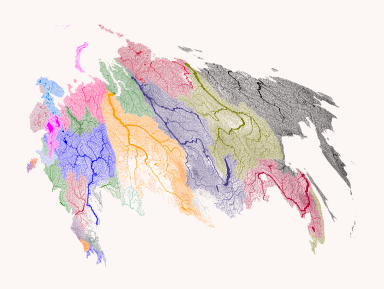

molobadekas Molodensky-Badekas transformation
Invalid projection: +proj=molobadekas +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1026 (Missing argument): molobadekas: helmert: missing 'convention' argument)
Call the gyno, cunts fucked
molodensky Molodensky transform
Invalid projection: +proj=molodensky +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1026 (Missing argument): molodensky: missing dx)
Call the gyno, cunts fucked
murd1 Murdoch I
Invalid projection: +proj=murd1 +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): murd1: Missing parameter: lat_1 should be specified)
Call the gyno, cunts fucked
murd2 Murdoch II
Invalid projection: +proj=murd2 +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): murd2: Missing parameter: 

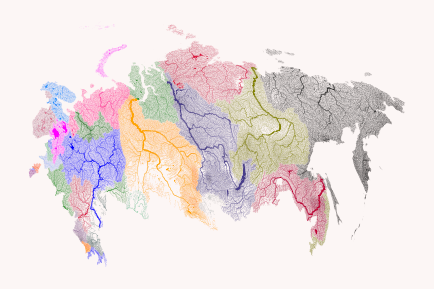

natearth2 Natural Earth 2


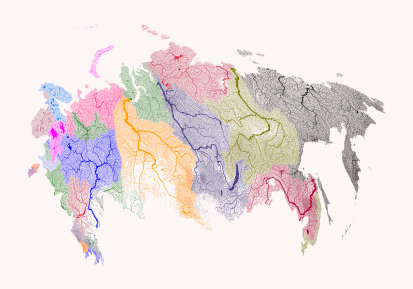

nell Nell


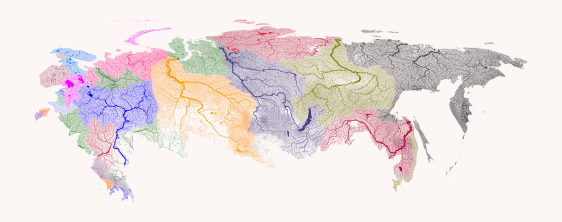

nell_h Nell-Hammer


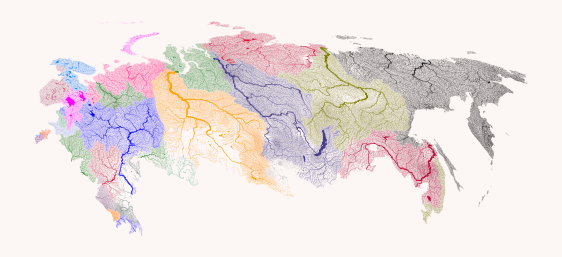

nicol Nicolosi Globular


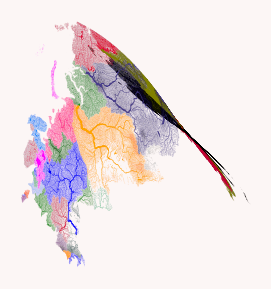

nsper Near-sided perspective
Invalid projection: +proj=nsper +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): nsper: Invalid value for h)
Call the gyno, cunts fucked
nzmg New Zealand Map Grid


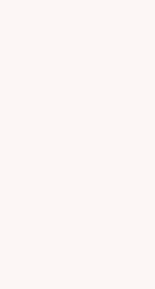

noop No operation


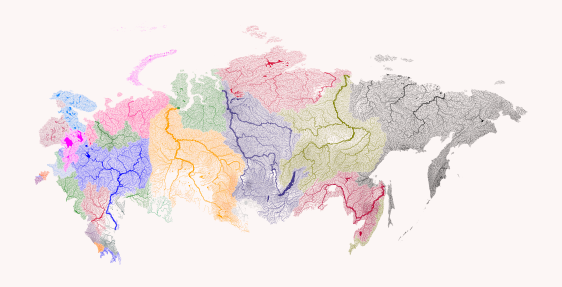

ob_tran General Oblique Transformation
Invalid projection: +proj=ob_tran +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1026 (Missing argument): ob_tran: Missing parameter: o_proj)
Call the gyno, cunts fucked
ocea Oblique Cylindrical Equal Area


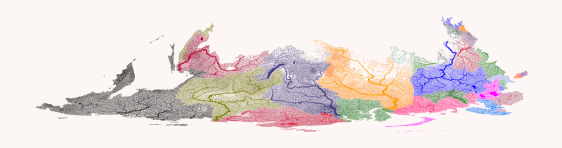

oea Oblated Equal Area
Invalid projection: +proj=oea +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): oea: Invalid value for n: it should be > 0)
Call the gyno, cunts fucked
omerc Oblique Mercator
Invalid projection: +proj=omerc +a=6378137.0 +lat_0=0.0 +lon_0=0.0 +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): omerc: Invalid value for lat_1/lat_2: lat_1 should be different from lat_2)
Call the gyno, cunts fucked
ortel Ortelius Oval


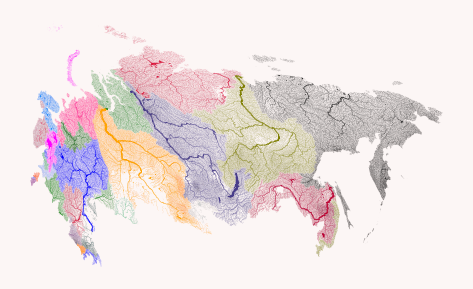

ortho Orthographic


KeyboardInterrupt: 

In [41]:
import pyproj 
from pyproj import CRS

for x, y in pyproj.pj_list.items():
    try:
        if x not in ignore:
            print(x, y)
            projection = TestProjection(name=x)
            fig = plt.figure(facecolor='#FCF6F5FF')
            fig.set_size_inches(7, 3.5)
            ax = plt.axes(projection=projection)
            rivers_basins_test.plot(ax=ax, edgecolor='face', 
                               color=rivers_basins_test['colors'], 
                               lw=rivers_basins_test['LW_DIST_UP_KM'],
                              transform=ccrs.Geodetic())
            lakes.plot(ax=ax, color=lakes['colors'], transform=ccrs.Geodetic())

            ax.axis('off')

            plt.savefig(f"outputs/russia/{x}.png", dpi=600, bbox_inches='tight')
            plt.show()
    except Exception as e:
        print(e)
        print("Call the gyno, cunts fucked")